# Import Required Libraries
Import the necessary libraries, including GeoPandas, Shapely, and Pandas.

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt

data_path = Path('London_UK')

# Load data
panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
network = gpd.read_file(data_path / 'network/edges/edges.geojson')

# Load Street Network Data
Load the street network data from a GeoJSON file or other data source.

In [2]:
# Load Street Network Data
streets = network  # Replace with your data source

# Load Image GPS Coordinates
Create a DataFrame with image IDs and their corresponding GPS coordinates.

In [3]:
# Load Image GPS Coordinates
# Create a DataFrame with image IDs and their corresponding GPS coordinates

image_data = {
    'image_id': np.linspace(0, len(panoids) - 1, len(panoids)),
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

In [19]:
import geopandas as gpd
from shapely.geometry import LineString

def split_line_max_length(line, max_segment_length=50):
    # Calculate the number of segments
    num_segments = int(line.length // max_segment_length) + 1
    segment_length = line.length / num_segments
    
    # Create a list to store the segments
    segments = []
    
    # Generate points along the line at each segment length
    for i in range(num_segments):
        start_point = line.interpolate(i * segment_length)
        end_point = line.interpolate(min((i + 1) * segment_length, line.length))
        segment = LineString([start_point, end_point])
        segments.append(segment)
    
    return segments

# Load the streets data
streets = gpd.read_file('London_UK/network/edges/edges.geojson')

# Re-project to a suitable CRS if necessary
if streets.crs.is_geographic:
    streets = streets.to_crs(epsg=27700)  # Use a projected CRS like EPSG:28992 for the Netherlands

# Calculate lengths
streets['length'] = streets.length

# Split lines longer than 100 meters
split_segments = []
for _, row in streets.iterrows():
    if row['length'] > 100:
        split_segments.extend(split_line(row['geometry'], max_segment_length=50))
    else:
        split_segments.append(row['geometry'])

# Create a new GeoDataFrame with the split segments
split_streets_gdf_max = gpd.GeoDataFrame(geometry=split_segments, crs=streets.crs)

# Optionally, calculate the new lengths
split_streets_gdf_max['length'] = split_streets_gdf_max.length

# Display the result
print(split_streets_gdf_max)


                                               geometry     length
0     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)  32.170470
1     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)  45.300592
2     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)  45.300604
3     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)  38.068030
4     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+...  27.608309
...                                                 ...        ...
5807  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)  33.085927
5808  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)  37.847271
5809  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)  37.768642
5810  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)   3.006542
5811  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+...  94.306510

[5812 rows x 2 columns]


In [21]:
import geopandas as gpd
from shapely.geometry import LineString
from shapely.ops import linemerge

def merge_short_lines(streets_gdf, min_total_length=50, max_individual_length=10):
    merged_segments = []
    current_merge = []

    for _, row in streets_gdf.iterrows():
        line = row['geometry']
        line_length = line.length

        if line_length < max_individual_length:
            current_merge.append(line)
            total_length = sum([seg.length for seg in current_merge])

            if total_length >= min_total_length:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
        else:
            if current_merge:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
            merged_segments.append(line)

    # If there are any remaining lines in the current merge, add them
    if current_merge:
        merged_line = linemerge(current_merge)
        merged_segments.append(merged_line)

    return gpd.GeoDataFrame(geometry=merged_segments, crs=streets_gdf.crs)



# Merge short lines
merged_streets_gdf_max = merge_short_lines(split_streets_gdf_max)

# Optionally, calculate the new lengths
merged_streets_gdf_max['length'] = merged_streets_gdf_max.length

merged_streets_gdf_max


geometry     length
0     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)  32.170470
1     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)  45.300592
2     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)  45.300604
3     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)  38.068030
4     LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+...  27.608309
...                                                 ...        ...
5026  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)  33.085927
5027  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)  37.847271
5028  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)  37.768642
5029  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)   3.006542
5030  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+...  94.306510

[5031 rows x 2 columns]

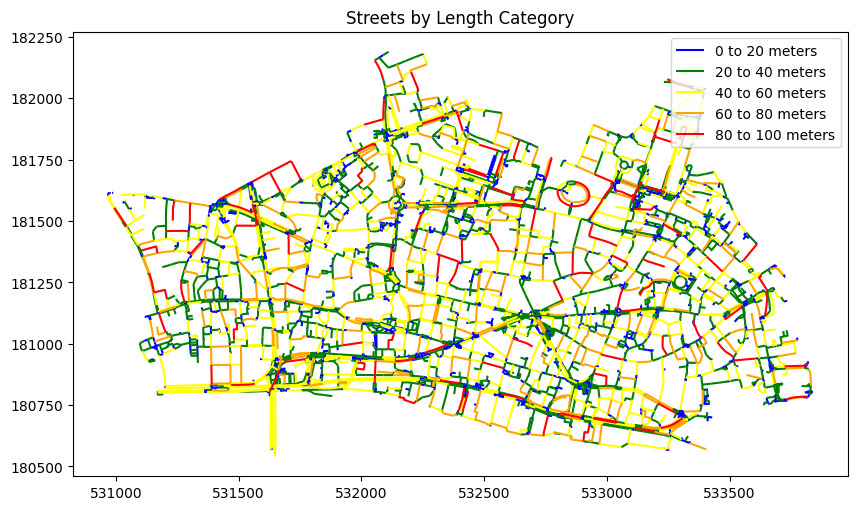

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Define a function to categorize lengths and assign colors
def categorize_and_plot(gdf):
    # Define the bins and corresponding colors
    bins = [0, 20, 40, 60, 80, 100]
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    
    # Create a new column 'category' based on the length
    gdf['category'] = np.digitize(gdf['length'], bins, right=True)
    
    # Plot each category with a different color
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, color in enumerate(colors, start=1):
        category_gdf = gdf[gdf['category'] == i]
        if not category_gdf.empty:
            category_gdf.plot(ax=ax, color=color, label=f'{bins[i-1]} to {bins[i]} meters')
    
    plt.title('Streets by Length Category')
    plt.legend()
    plt.show()



# Call the function to categorize and plot
categorize_and_plot(merged_streets_gdf_max)

In [26]:
import geopandas as gpd
from shapely.geometry import Point, MultiPoint

# Load the streets data if not already loaded
streets = gpd.read_file('London_UK/network/edges/edges.geojson')

# Create a list to store intersection points
intersection_points = []

# Iterate over each pair of LineStrings to find intersections
for i, line1 in enumerate(streets['geometry']):
    for j, line2 in enumerate(streets['geometry']):
        if i >= j:  # Avoid duplicate checks and self-intersection
            continue
        if line1.intersects(line2):
            intersection = line1.intersection(line2)
            if intersection.geom_type == 'Point':
                intersection_points.append(intersection)
            elif intersection.geom_type == 'MultiPoint':
                intersection_points.extend(intersection.geoms)

# Create a GeoDataFrame for the intersection points
intersection_gdf = gpd.GeoDataFrame(geometry=intersection_points, crs=streets.crs)

# Display the first few rows of the GeoDataFrame
print(intersection_gdf.head())

                   geometry
0   POINT (-0.08535 51.509)
1   POINT (-0.08535 51.509)
2  POINT (-0.083659 51.509)
3  POINT (-0.083659 51.509)
4  POINT (-0.085886 51.509)


In [29]:
# Remove duplicate points, keeping only the first occurrence
intersection_gdf_unique = intersection_gdf.drop_duplicates(subset='geometry')

# Print the resulting GeoDataFrame
len(intersection_gdf)

12030

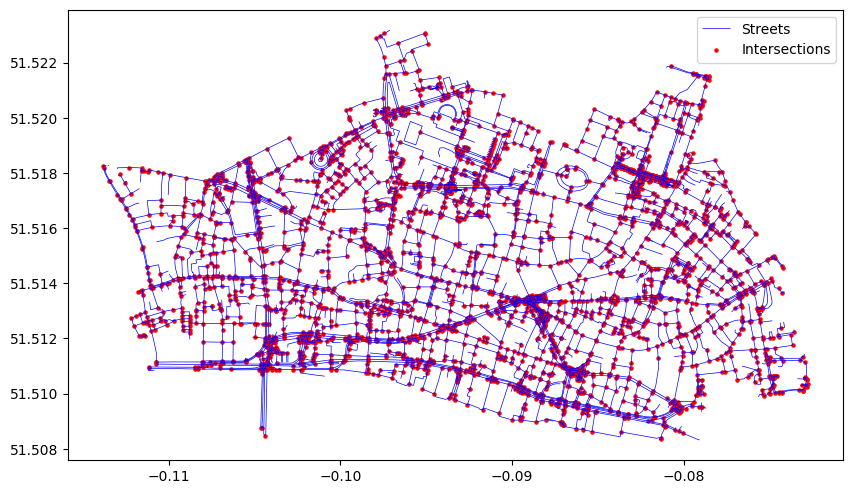

In [28]:

# Assuming intersection_gdf is already created and contains intersection points
# intersection_gdf = gpd.GeoDataFrame(...)  # Your existing intersection GeoDataFrame

# Plot the streets and intersection points
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, color='blue', linewidth=0.5, label='Streets')
intersection_gdf_unique.plot(ax=ax, color='red', marker='o', markersize=5, label='Intersections')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [30]:
import geopandas as gpd
from shapely.geometry import LineString, Point
from shapely.ops import split

# Load the streets data if not already loaded
streets = gpd.read_file('London_UK/network/edges/edges.geojson')

# Ensure intersection points are unique
intersection_points = intersection_gdf_unique['geometry'].unique()

# Function to split a line at given points
def split_line_at_points(line, points):
    # Sort points along the line
    points = sorted(points, key=lambda point: line.project(point))
    # Split the line at each point
    segments = []
    for point in points:
        # Split the line at the point
        split_result = split(line, point)
        # Add the segments to the list
        segments.extend(split_result.geoms)
    return segments

# List to store the split lines
split_lines = []

# Iterate over each line in the streets GeoDataFrame
for line in streets['geometry']:
    # Find intersection points that lie on the current line
    line_points = [point for point in intersection_points if line.intersects(point)]
    if line_points:
        # Split the line at these points
        split_segments = split_line_at_points(line, line_points)
        split_lines.extend(split_segments)
    else:
        # If no intersection points, add the line as is
        split_lines.append(line)

# Create a new GeoDataFrame with the split lines
split_streets_gdf = gpd.GeoDataFrame(geometry=split_lines, crs=streets.crs)

# Display the result
print(split_streets_gdf.head())

                                                geometry
0      LINESTRING (-0.083659 51.509, -0.083712 51.508...
1      LINESTRING (-0.083659 51.509, -0.083712 51.508...
2         LINESTRING (-0.085886 51.509, -0.08535 51.509)
3         LINESTRING (-0.085886 51.509, -0.08535 51.509)
4      LINESTRING (-0.085886 51.509, -0.086233 51.509...
...                                                  ...
10253    LINESTRING (-0.080744 51.521, -0.081099 51.521)
10254  LINESTRING (-0.081004 51.522, -0.080984 51.522...
10255       LINESTRING (-0.0808 51.522, -0.08076 51.522)
10256  LINESTRING (-0.08076 51.522, -0.079787 51.522,...
10257  LINESTRING (-0.08076 51.522, -0.079787 51.522,...

[10258 rows x 1 columns]


In [31]:
import geopandas as gpd

# Ensure the GeoDataFrame is in a projected CRS
# For example, using EPSG:27700 (British National Grid) or any other suitable projected CRS
if split_streets_gdf.crs.is_geographic:
    split_streets_gdf = split_streets_gdf.to_crs(epsg=27700)

# Calculate the length of each LineString
split_streets_gdf['length'] = split_streets_gdf.length

# Display the result
print(split_streets_gdf[['geometry', 'length']])

                                                geometry      length
0      LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+...  135.901812
1      LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+...  135.901812
2      LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)   38.068030
3      LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+05)   38.068030
4      LINESTRING (5.33e+05 1.81e+05, 5.33e+05 1.81e+...   27.608309
...                                                  ...         ...
10253  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)   26.361131
10254  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+...  113.541814
10255  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+05)    3.006542
10256  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+...   94.306510
10257  LINESTRING (5.33e+05 1.82e+05, 5.33e+05 1.82e+...   94.306510

[10258 rows x 2 columns]


In [32]:
import geopandas as gpd
import folium  # Import folium for map controls



# Ensure intersection_gdf_unique is in the same CRS as streets
intersection_gdf_unique = intersection_gdf_unique.to_crs(streets.crs)

# Use the .explore() method to visualize both GeoDataFrames
m = split_streets_gdf.explore(
    color='blue',  # Color for streets
    tooltip='length',  # Tooltip to show length if available
    name='Streets'
)

intersection_gdf_unique.explore(
    m=m,
    color='red',  # Color for intersection points
    marker_kwds={'radius': 5},  # Marker size for points
    name='Intersection Points'
)

# Add layer control to toggle between layers
m.add_child(folium.LayerControl())

# Display the map
m


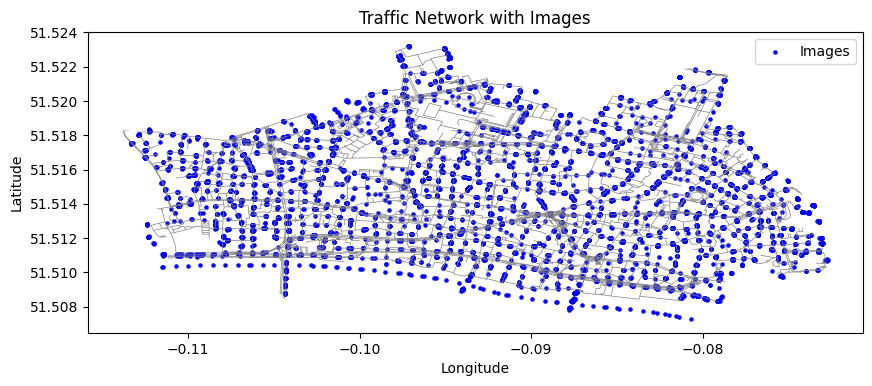

In [36]:


# Perform Spatial Join to find nearest street for each image
matched_split = gpd.sjoin_nearest(images_gdf, split_streets_gdf, how='left', distance_col='distance')
# Function to get coordinates by image ID
def get_coords_by_image_id(image_id):
    row = matched_split[matched_split['image_id'] == image_id]
    if not row.empty:
        return row['geometry'].values[0].x, row['geometry'].values[0].y
    else:
        return None, None

# Visualize the traffic network with images
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, color='gray', linewidth=0.5)
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images')
plt.legend()

plt.show()

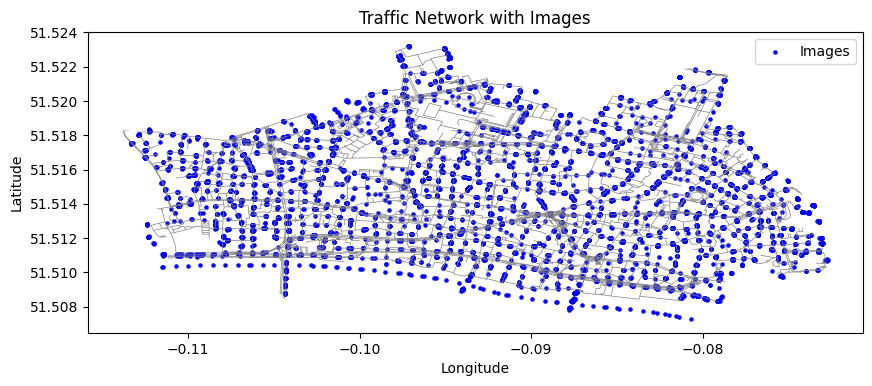

In [37]:

merged_streets_gdf_max = merged_streets_gdf_max.to_crs(images_gdf.crs)

# Perform Spatial Join to find nearest street for each image
matched_max = gpd.sjoin_nearest(images_gdf, merged_streets_gdf_max, how='left', distance_col='distance')

# Function to get coordinates by image ID
def get_coords_by_image_id(image_id):
    row = matched_max[matched_max['image_id'] == image_id]
    if not row.empty:
        return row['geometry'].values[0].x, row['geometry'].values[0].y
    else:
        return None, None

# Visualize the traffic network with images
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, color='gray', linewidth=0.5)
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images')
plt.legend()
plt.show()

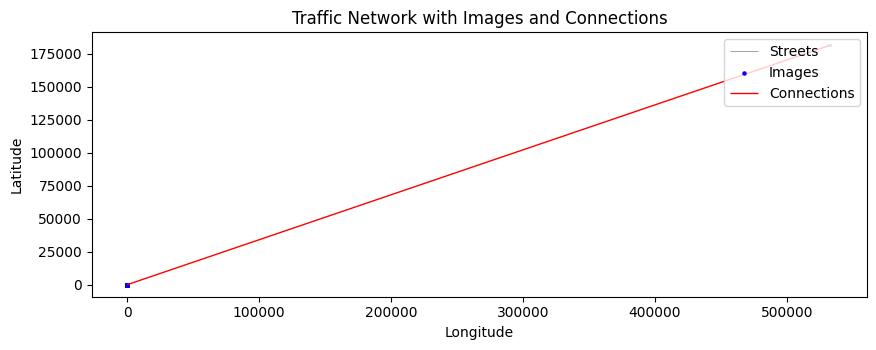

In [51]:

connecting_lines = []
for idx, row in matched_max.iterrows():
    image_point = row['geometry']
    nearest_line_index = row['index_right']  # This is the index of the nearest line
    nearest_line = merged_streets_gdf_max.loc[nearest_line_index, 'geometry']  # Get the actual LineString
    connecting_line = LineString([image_point, nearest_line.interpolate(nearest_line.project(image_point))])
    connecting_lines.append(connecting_line)

# Create a GeoDataFrame for the connecting lines
connecting_lines_gdf = gpd.GeoDataFrame(geometry=connecting_lines, crs=merged_streets_gdf_max.crs)

# Visualize the traffic network with images and connecting lines
fig, ax = plt.subplots(figsize=(10, 10))
merged_streets_gdf_max.plot(ax=ax, color='gray', linewidth=0.5, label='Streets')
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')
connecting_lines_gdf.plot(ax=ax, color='red', linewidth=1, label='Connections')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images and Connections')
plt.legend()
plt.show()




C:\Users\yigit\AppData\Local\Temp\ipykernel_9260\3935755343.py:32: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: EPSG:4326

  matched = gpd.sjoin_nearest(merged_streets_gdf_max, images_gdf, how='left', distance_col='distance')
c:\Users\yigit\anaconda3\anaconda goeie\envs\street\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


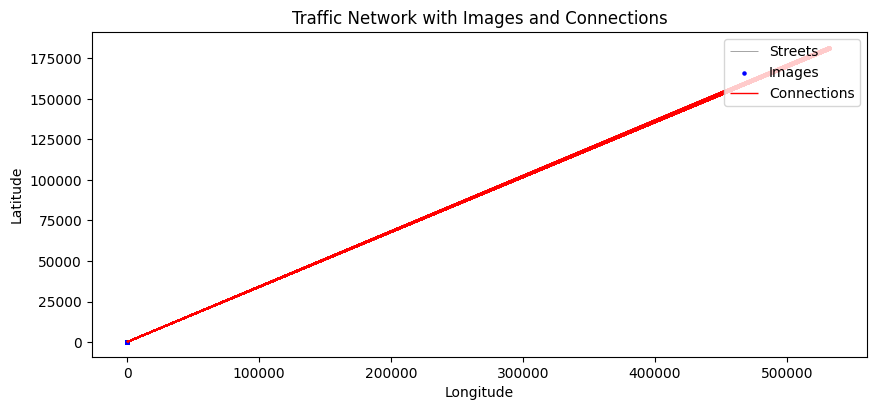

In [48]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming panoids DataFrame has columns 'panoid', 'lng', and 'lat'
# Example:
# panoids = pd.DataFrame({
#     'panoid': ['id1', 'id2', 'id3'],
#     'lng': [-0.10543, -0.0949, -0.10601],
#     'lat': [51.51575, 51.51736, 51.51575]
# })

# Create a DataFrame with image IDs and their corresponding GPS coordinates
image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids.panoid,
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

# Ensure merged_streets_gdf is in the same CRS as images_gdf
merged_streets_gdf = merged_streets_gdf_max.to_crs(images_gdf.crs)

# Perform Spatial Join to find nearest image for each street segment
matched = gpd.sjoin_nearest(merged_streets_gdf_max, images_gdf, how='left', distance_col='distance')

# Create lines connecting each street segment to its nearest image
connecting_lines = []
for idx, row in matched.iterrows():
    line_segment = row['geometry']
    nearest_image_index = row['index_right']  # This is the index of the nearest image
    nearest_image_point = images_gdf.loc[nearest_image_index, 'geometry']  # Get the actual Point
    connecting_line = LineString([line_segment.interpolate(line_segment.project(nearest_image_point)), nearest_image_point])
    connecting_lines.append(connecting_line)

# Create a GeoDataFrame for the connecting lines
connecting_lines_gdf = gpd.GeoDataFrame(geometry=connecting_lines, crs=merged_streets_gdf.crs)

# Visualize the traffic network with images and connecting lines
fig, ax = plt.subplots(figsize=(10, 10))
merged_streets_gdf.plot(ax=ax, color='gray', linewidth=0.5, label='Streets')
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')
connecting_lines_gdf.plot(ax=ax, color='red', linewidth=1, label='Connections')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images and Connections')
plt.legend()
plt.show()

c:\Users\yigit\anaconda3\anaconda goeie\envs\street\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


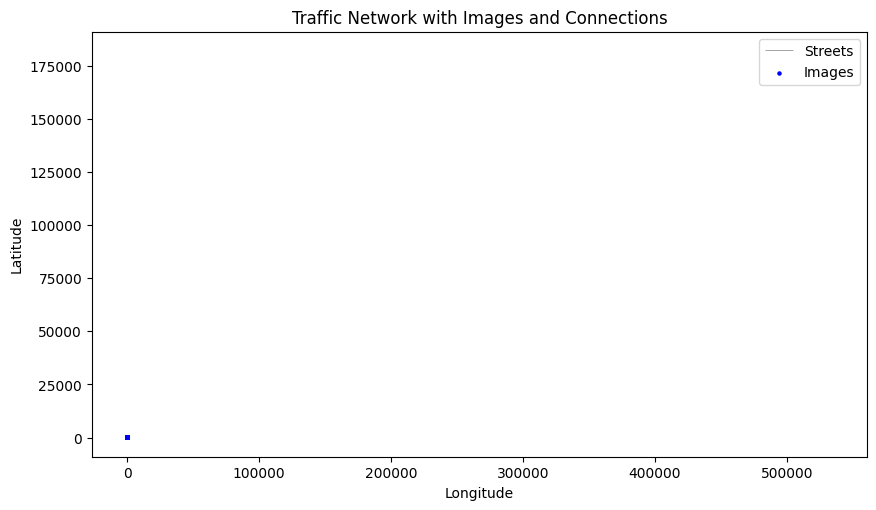

In [49]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming panoids DataFrame has columns 'panoid', 'lng', and 'lat'
# Example:
# panoids = pd.DataFrame({
#     'panoid': ['id1', 'id2', 'id3'],
#     'lng': [-0.10543, -0.0949, -0.10601],
#     'lat': [51.51575, 51.51736, 51.51575]
# })

# Create a DataFrame with image IDs and their corresponding GPS coordinates
image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids.panoid,
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

# Ensure merged_streets_gdf is in the same CRS as images_gdf
merged_streets_gdf = merged_streets_gdf.to_crs(images_gdf.crs)

# Perform Spatial Join to find nearest image for each street segment
matched = gpd.sjoin_nearest(merged_streets_gdf, images_gdf, how='left', distance_col='distance')

# Sort by distance and drop duplicates to keep only the closest image per street
matched = matched.sort_values(by='distance').drop_duplicates(subset='index_right')



# Visualize the traffic network with images and connecting lines
fig, ax = plt.subplots(figsize=(10, 10))
merged_streets_gdf_max.plot(ax=ax, color='gray', linewidth=0.5, label='Streets')
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')


# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images and Connections')
plt.legend()
plt.show()